In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pickle
import time
import os
import pickle
import seaborn as sns
import scipy.stats
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
# Load Meta-Data
PATH = "/kaggle/input/ariel-data-challenge-2024"
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv', 
                             index_col='planet_id')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')
wavelengths = pd.read_csv(f'{PATH}/wavelengths.csv')

# Pre-Processing
## Load Functions

In [3]:
%%writefile utils.py
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
import pickle
PATH = "/kaggle/input/ariel-data-challenge-2024"
def load_signal_data(planet_id, dataset, instrument, img_size):
    file_path = f'{PATH}/{dataset}/{planet_id}/{instrument}_signal.parquet'
    signal = pl.read_parquet(file_path)
    mean_signal = signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / img_size # mean over the 32*32 pixels
    net_signal = mean_signal[1::2] - mean_signal[0::2]
    return net_signal

def read_and_preprocess(dataset, planet_ids, instrument = "AIRS-CH0"):
    """Read the files for all planet_ids and extract the time series.
    Parameters
    dataset: 'train' or 'test'
    planet_ids: list of planet ids
    instrument: the instrument of observation, 'AIRS-CH0' or 'FGS1', default to 'AIRS-CH0'
    Returns
    dataframe with one row per planet_id and 67500 values per row for FGS1 and 5624 for AIRS-CH0
    """
    img_size = 1024 if instrument == "FGS1" else 32*356
    column_num = 67500 if instrument == 'FGS1' else 5625
    raw_train = np.full((len(planet_ids), column_num), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        raw_train[i] = load_signal_data(planet_id, dataset, instrument, img_size)
    return raw_train

def feature_engineering(f_raw, a_raw, adc_info, window_size=60, step_size=15):
    """Create a dataframe with combined features from the raw data, including sliding window and time-series statistics.
    
    Parameters:
    f_raw: ndarray of shape (n_planets, 67500)
    a_raw: ndarray of shape (n_planets, 5625)
    window_size: int, size of the sliding window for time-series statistics
    step_size: int, step size for the sliding window
    
    Return value:
    df: DataFrame of shape (n_planets, several features)
    """
    f_obscured = f_raw[:, 23500:44000].mean(axis=1)
    f_unobscured = (f_raw[:, :20500].mean(axis=1) + f_raw[:, 47000:].mean(axis=1)) / 2
    f_relative_reduction = (f_unobscured - f_obscured) / f_unobscured
    f_std_dev = f_raw.std(axis=1)
    f_signal_to_noise = f_unobscured / f_std_dev

    a_obscured = a_raw[:, 1958:3666].mean(axis=1)
    a_unobscured = (a_raw[:, :1708].mean(axis=1) + a_raw[:, 3916:].mean(axis=1)) / 2
    a_relative_reduction = (a_unobscured - a_obscured) / a_unobscured
    a_std_dev = a_raw.std(axis=1)
    a_signal_to_noise = a_unobscured / a_std_dev

    f_variance = f_raw.var(axis=1)
    a_variance = a_raw.var(axis=1)
    
    f_skewness = pd.DataFrame(f_raw).skew(axis=1).values
    a_skewness = pd.DataFrame(a_raw).skew(axis=1).values

    f_kurtosis = pd.DataFrame(f_raw).kurtosis(axis=1).values
    a_kurtosis = pd.DataFrame(a_raw).kurtosis(axis=1).values
    
    f_half_obscured1 = f_raw[:, 20500:23500].mean(axis=1)
    f_half_obscured2 = f_raw[:, 44000:47000].mean(axis=1)
    f_half_reduction1 = (f_unobscured - f_half_obscured1) / f_unobscured
    f_half_reduction2 = (f_unobscured - f_half_obscured2) / f_unobscured

    a_half_obscured1 = a_raw[:, 1708:1958].mean(axis=1)
    a_half_obscured2 = a_raw[:, 3666:3916].mean(axis=1)
    a_half_reduction1 = (a_unobscured - a_half_obscured1) / a_unobscured
    a_half_reduction2 = (a_unobscured - a_half_obscured2) / a_unobscured

    # Sliding window features
    def sliding_window_features(data, window_size, step_size):
        features = []
        max_index = data.shape[1]
        for start in range(0, max_index - window_size + 1, step_size):
            end = start + window_size
            window = data[:, start:end]
            features.append([
                np.mean(window, axis=1),
                np.std(window, axis=1),
                np.min(window, axis=1),
                np.max(window, axis=1),
                np.percentile(window, 5, axis=1),
                np.percentile(window, 10, axis=1),
                np.percentile(window, 15, axis=1),
                np.percentile(window, 20, axis=1),
                np.percentile(window, 25, axis=1),
                np.percentile(window, 30, axis=1),
                np.percentile(window, 35, axis=1),
                np.percentile(window, 40, axis=1),
                np.percentile(window, 60, axis=1),
                np.percentile(window, 65, axis=1),
                np.percentile(window, 70, axis=1),
                np.percentile(window, 75, axis=1),
                np.percentile(window, 80, axis=1),
                np.percentile(window, 85, axis=1),
                np.percentile(window, 90, axis=1),
                np.percentile(window, 95, axis=1),
                np.median(window, axis=1),
                np.var(window, axis=1),
#                 kurtosis(window, axis=1),
#                 skew(window, axis=1),
            ])
        if features:
            return np.vstack(features).T  # Stack vertically and transpose to get the correct shape
        else:
            return np.empty((data.shape[0], 0))  # Return empty array with correct shape
    
    f_sliding_features = sliding_window_features(f_raw, window_size, step_size)
    a_sliding_features = sliding_window_features(a_raw, window_size, step_size)
    
    f_sliding_features2 = sliding_window_features(f_raw, 150, 10)
    a_sliding_features2 = sliding_window_features(a_raw, 150, 10)


    print(f'f_sliding_features.shape: {f_sliding_features.shape}')
    print(f'a_sliding_features.shape: {a_sliding_features.shape}')


    df = pd.DataFrame({
        'f_relative_reduction': f_relative_reduction,
        'f_signal_to_noise': f_signal_to_noise,
        'f_variance': f_variance,
        'f_skewness': f_skewness,
        'f_kurtosis': f_kurtosis,
        'a_relative_reduction': a_relative_reduction,
        'a_signal_to_noise': a_signal_to_noise,
        'a_variance': a_variance,
        'a_skewness': a_skewness,
        'a_kurtosis': a_kurtosis,
        'f_half_reduction1': f_half_reduction1,
        'f_half_reduction2': f_half_reduction2,
        'a_half_reduction1': a_half_reduction1,
        'a_half_reduction2': a_half_reduction2
    })


    if f_sliding_features.size > 0:
        f_sliding_df = pd.DataFrame(f_sliding_features, columns=[f'f_slide_{i}' for i in range(f_sliding_features.shape[1])])
        df = pd.concat([df, f_sliding_df], axis=1)
    if a_sliding_features.size > 0:
        a_sliding_df = pd.DataFrame(a_sliding_features, columns=[f'a_slide_{i}' for i in range(a_sliding_features.shape[1])])
        df = pd.concat([df, a_sliding_df], axis=1)
    
    if f_sliding_features2.size > 0:
        f_sliding_df = pd.DataFrame(f_sliding_features2, columns=[f'f_slide2_{i}' for i in range(f_sliding_features2.shape[1])])
        df = pd.concat([df, f_sliding_df], axis=1)
    if a_sliding_features2.size > 0:
        a_sliding_df = pd.DataFrame(a_sliding_features2, columns=[f'a_slide2_{i}' for i in range(a_sliding_features2.shape[1])])
        df = pd.concat([df, a_sliding_df], axis=1)
    
    
    df = pd.concat([df, adc_info.reset_index().iloc[:, 1:6]], axis=1)
    
    return df

Writing utils.py


In [4]:
%%writefile -a utils.py

def postprocessing(pred_array, index, sigma_pred):
    """Create a submission dataframe from its components
    
    Parameters:
    pred_array: ndarray of shape (n_samples, 283)
    index: pandas.Index of length n_samples with name 'planet_id'
    sigma_pred: float
    
    Return value:
    df: DataFrame of shape (n_samples, 566) with planet_id as index
    """
    return pd.concat([pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns),
                      pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)

class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
        row_id_column_name='planet_id',
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

Appending to utils.py


In [5]:
exec(open('utils.py', 'r').read())

## Load Data

In [6]:
%%time
if os.path.exists("/kaggle/input/adc24-intro-training/f_raw_train.pickle"):
    f_raw_train = np.load('/kaggle/input/adc24-intro-training/f_raw_train.pickle', allow_pickle=True)
else:
    f_raw_train = read_and_preprocess('train', train_labels.index, 'FGS1')
    with open('f_raw_train.pickle', 'wb') as f:
        pickle.dump(f_raw_train, f)

CPU times: user 0 ns, sys: 356 ms, total: 356 ms
Wall time: 1.72 s


In [7]:
%%time
if os.path.exists("/kaggle/input/adc24-intro-training/a_raw_train.pickle"):
    a_raw_train = np.load('/kaggle/input/adc24-intro-training/a_raw_train.pickle', allow_pickle=True)
else:
    a_raw_train = read_and_preprocess('train', train_labels.index)
    with open('a_raw_train.pickle', 'wb') as f:
        pickle.dump(a_raw_train, f)

CPU times: user 2.03 ms, sys: 27.4 ms, total: 29.4 ms
Wall time: 79.1 ms


## Feature Engineering

In [8]:
%%time
train = feature_engineering(f_raw_train, a_raw_train, train_adc_info)

f_sliding_features.shape: (673, 98934)
a_sliding_features.shape: (673, 8184)
CPU times: user 5min 59s, sys: 9.71 s, total: 6min 9s
Wall time: 6min 9s


In [9]:
train.head()

,f_relative_reduction,f_signal_to_noise,f_variance,f_skewness,f_kurtosis,a_relative_reduction,a_signal_to_noise,a_variance,a_skewness,a_kurtosis,...,a_slide2_12051,a_slide2_12052,a_slide2_12053,a_slide2_12054,a_slide2_12055,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star
0,0.001236,247.858444,0.838030,0.134635,-0.020934,0.001993,900.441284,2.375195,0.206184,-0.907031,...,1387.502454,1387.592407,1387.773926,1387.033936,0.191866,-343.335938,0.837244,-778.916533,0.924746,1
1,0.001673,246.668182,0.851911,0.127880,-0.053412,0.001981,1001.031799,1.925676,-0.394453,-1.308808,...,1390.112292,1390.262097,1390.440161,1389.738159,0.149866,-366.381992,0.842983,-740.323212,0.931727,1
2,0.003110,208.025421,1.215398,0.035672,-0.057277,0.002974,629.504089,4.661981,-0.081897,-1.224823,...,1361.622357,1361.743799,1362.035236,1361.139160,0.297251,-386.107037,1.041701,-808.690659,1.513541,0
3,0.000933,247.863846,0.839834,0.147155,-0.034857,0.001435,1366.114136,1.033238,-0.467466,-1.185194,...,1388.856860,1388.904419,1388.972662,1388.541748,0.121831,-339.737490,0.840239,-776.124167,0.931277,1
4,0.001916,210.724655,1.186640,0.158346,-0.036270,0.002177,706.390808,3.677194,0.277355,-0.992068,...,1357.513507,1357.634619,1357.855457,1356.917603,0.316233,-355.660433,1.041280,-848.371494,1.503923,0


In [10]:
train = train.iloc[:,:-1]

## Data Plot

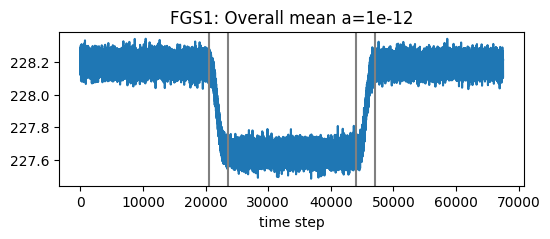

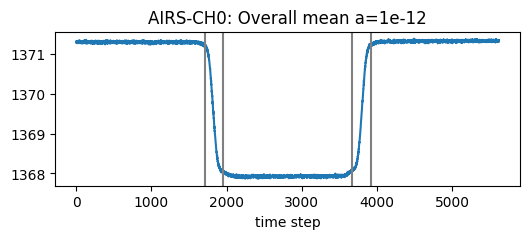

In [11]:
plt.figure(figsize=(6, 2))
plt.plot(f_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step, color='gray')
plt.xlabel('time step')
plt.title('FGS1: Overall mean a=1e-12')
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(a_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step * 11250 // 135000, color='gray')
plt.xlabel('time step')
plt.title('AIRS-CH0: Overall mean a=1e-12')
plt.show()

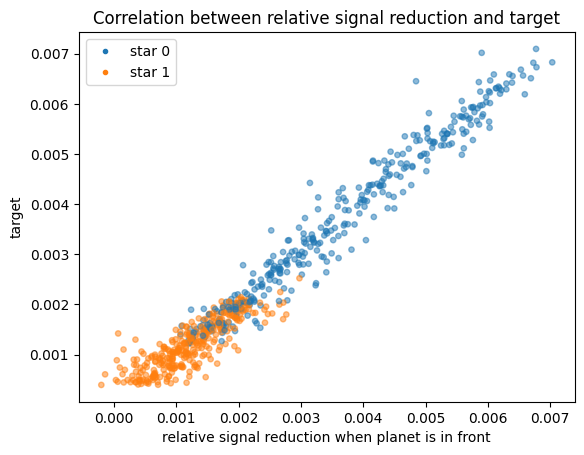

In [12]:
color_array = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.scatter(train.a_relative_reduction, train_labels.wl_1, s=15, alpha=0.5,
            c=color_array[train_adc_info.star])
plt.xlabel('relative signal reduction when planet is in front')
plt.ylabel('target')
plt.title('Correlation between relative signal reduction and target')
# plt.gca().set_aspect('equal')
points = [plt.Line2D([0], [0], label=f'star {i}', marker='o', markersize=3,
         markeredgecolor=color_array[i], markerfacecolor=color_array[i], linestyle='') for i in range(2)]

plt.legend(handles=points)
plt.show()

# Model
## Rigde Model

In [13]:
model = Ridge(alpha=1e8)

oof_pred = cross_val_predict(model, train, train_labels)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.4f}")
sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
print(f"# Root mean squared error: {sigma_pred:.7f}")

# R2 score: 0.6716
# Root mean squared error: 0.0009889


In [14]:
oof_df = postprocessing(oof_pred, train_adc_info.index, sigma_pred)
display(oof_df)

gll_score = competition_score(train_labels.copy().reset_index(),
                              oof_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.000003)
print(f"# Estimated competition score: {gll_score:.4f}")

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
785834,0.001783,0.001807,0.001805,0.001803,0.001806,0.001802,0.001801,0.001806,0.001804,0.001803,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989
14485303,0.001623,0.001647,0.001646,0.001643,0.001647,0.001643,0.001642,0.001647,0.001645,0.001644,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989
17002355,0.003491,0.003525,0.003515,0.003509,0.003510,0.003499,0.003498,0.003511,0.003507,0.003500,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989
24135240,0.001306,0.001329,0.001328,0.001326,0.001329,0.001326,0.001325,0.001329,0.001328,0.001327,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989
25070640,0.003567,0.003602,0.003592,0.003584,0.003586,0.003574,0.003573,0.003586,0.003582,0.003575,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249337798,0.000593,0.000621,0.000620,0.000617,0.000620,0.000616,0.000615,0.000620,0.000618,0.000617,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989
4257395405,0.003247,0.003278,0.003271,0.003267,0.003267,0.003258,0.003258,0.003270,0.003267,0.003262,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989
4266129805,0.003818,0.003847,0.003839,0.003834,0.003834,0.003825,0.003825,0.003837,0.003834,0.003829,...,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989,0.000989


# Estimated competition score: 0.0814


In [15]:
model.fit(train, train_labels)
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
with open('sigma_pred.pickle', 'wb') as f:
    pickle.dump(sigma_pred, f)

## Inference

In [16]:
# Load the data
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
sample_submission = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv',
                                index_col='planet_id')
f_raw_test = read_and_preprocess('test', sample_submission.index, 'FGS1')
a_raw_test = read_and_preprocess('test', sample_submission.index)
test = feature_engineering(f_raw_test, a_raw_test, test_adc_info)
test = test.iloc[: , :-1]
# Load the model
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)
with open('sigma_pred.pickle', 'rb') as f:
    sigma_pred = pickle.load(f)

# Predict
test_pred = model.predict(test)

# Package into submission file
sub_df = sub_df = postprocessing(test_pred,
                        test_adc_info.index,
                        sigma_pred=np.tile(np.where(test_adc_info[['star']] <= 1, 0.0001555, 0.00085), (1, 283)))
display(sub_df)
sub_df.to_csv('submission.csv')

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


f_sliding_features.shape: (1, 98934)
a_sliding_features.shape: (1, 8184)


,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
499191466,0.001872,0.001897,0.001896,0.001893,0.001897,0.001893,0.001892,0.001896,0.001895,0.001894,...,0.000156,0.000156,0.000156,0.000156,0.000156,0.000156,0.000156,0.000156,0.000156,0.000156


In [19]:
# GLL
import numpy as np
import math

def calculate_gll(y_pred=0,y_true=0,sigmas=1e-5):
    var = sigmas**2
    mse = (y_pred - y_true)**2
    score = -0.5*(np.log(2*math.pi)+np.log(var)+mse/var)
    return round(score.mean(),3)


# L_ref
mn = np.mean(oof_df.values, axis=0, keepdims=True)
stdev = np.std(oof_df.values, axis=0, keepdims=True)
# L_ref = calculate_gll(mn,oof_df,stdev)
# L_ref_mean = round(L_ref.mean(), 3)
# print("L_ref_mean = ",L_ref_mean)
L_ref_mean=4.925

# L_ideal
L_ideal = calculate_gll()
L_ideal_mean = round(L_ideal.mean(),3)
print("L_ideal = ",L_ideal_mean)

# L
mn_test = np.mean(test_pred, axis=0, keepdims=True)
stdev_test = np.std(test_pred, axis=0, keepdims=True)
L = calculate_gll(mn_test, test_pred, stdev_test)
L_mean = round(L.mean(), 3)
print("L = ",L_mean)

L_ideal =  10.594
L =  nan


/tmp/ipykernel_33/2821516005.py:8: RuntimeWarning: divide by zero encountered in log
  score = -0.5*(np.log(2*math.pi)+np.log(var)+mse/var)
/tmp/ipykernel_33/2821516005.py:8: RuntimeWarning: invalid value encountered in divide
  score = -0.5*(np.log(2*math.pi)+np.log(var)+mse/var)


In [ ]:
# Score
score = (L_mean - L_ref_mean)/(L_ideal_mean - L_ref_mean)
print("Score = ",score)